# **DERIVING SPATIAL MAPS WITH PYFLWDIR in PYTHON**

# === **RUN WflowRaster.ipynb** ===


In [1]:
print("=== Please run WflowRaster.ipynb")


=== Please run WflowRaster.ipynb


# === **PARAMETERS** ===


In [2]:
# ======= FLAGS =======
Flag_BurnRiver = True
Flag_River     = True
Flag_Bassins   = True

# ======= PATHS =======
Path_Root   = "D:/JOE/MAIN/MODELS/WFLOW/DATA/Timoleague"
Path_Gis    = "InputGis"
Path_Julia  = "OutputJulia"
Path_Python = "OutputPython"

# ====== FILES NAME =======
# == Input ==
Filename_Input_DemJulia = "Timoleague_DEM.tiff"
Filename_Input_RiverShp = "Timoleague_River3.geojson"

# == Output for information ==
Filename_Output_RiverOrder           = "RiverAll_Order.tiff"
Filename_Output_RiverAllTrue         = "RiverAll_True.tiff"
Filename_Output_Basins_Tiff          = "Basins.tiff"
Filename_Output_Basins_Geojson       = "Basins.geojson"
Filename_Output_Subcatchment_Geojson = "Subcatchment.geojson"
Filename_Output_PitsBasins           = "PitsBasins.geojson"
Filename_Output_PitsSubcatchment     = "PitsSubcatchment.geojson"
Filename_Output_PitsBassins     	 = "PitsBassins.geojson"


# == Output for Julia Wflow ==
Filename_Output_DemCorrected = "DemCorrected.tiff"
Filename_Output_Ldd          = "Ldd.tiff"
Filename_Output_Ldd_Basins   = "Ldd_Basins.tiff"
Filename_Output_RiverLength  = "RiverLength.tiff"
Filename_Output_Slope        = "Slope.tiff"
Filename_Output_Subcatchment = "Subcatchment.tiff"

# ======= PARAMETERS =======
# == Ldd inputs ==
# (float, optional) Maximum pour point depth. Depressions with a larger pour point depth are set as pit. A negative value (default) equals an infinitely large pour point depth causing all depressions to be filled.
Param_PitMaxDepth = -1.0

Param_RiverDepth = 5.0  # if Flag_BurnRiver (float) – fixed depth value used to burn in the dem

Param_RiverBurnMethod = "fixed"

Param_RiverOrderMethod = "strahler"  # <"classic"*>  or <"strahler"> or  stream order map. In the classic “bottum up” stream order map, the main river stem has order 1. Each tributary is given a number one greater than that of the river or stream into which they discharge. In the strahler “top down” stream order map, rivers of the first order are the most upstream tributaries or head water cells. If two streams of the same order merge, the resulting stream has an order of one higher. If two rivers with different stream orders merge, the resulting stream is given the maximum of the two order.

# Plotting rivers
Param_RiverOrderMin_Strahler = 7 # Depending on Param_RiverOrderMethod
Param_RiverOrderMax_Classic  = 2  # Depending on Param_RiverOrderMethod

# Param_LddMethod = "Hydromet" # <"Pcraster">; <"Pyflwdir">;<"Hydromet">

# Param_OutletMethod can be defined at edges of the grid (defualt) or force all flow to go to the minimum elevation point min. The latter only makes sense if your DEM only is masked to the catchment. Additionnally, the user can also force specific pits locations via idxs_pit.
# Param_OutletMethod = "edge"  # "edge","min"

# == Other ==
Param_NoData = 255  # Not yet applicable

Param_Crs = 29902  # [-] This is the default projection TM65 / Irish Grid

# The coordinate need to be shifted such that it is in the river network, it is very sensitive
# Param_GaugeCoordinate_Timoleague = [146707.7, 42167.995]
# Param_GaugeCoordinate = [146705.520,42165.261]
# Param_GaugeCoordinate =   [146700.2167,42159.7300]
# Param_GaugeCoordinate =[146690.673,42139.540]
Param_GaugeCoordinate =[146688.917,42121.998]

# TODO: merge with Parameters.jl

print("==== JULIA CODE NEEDS TO BE RUN ====")


==== JULIA CODE NEEDS TO BE RUN ====


# === **UTILS** === 
## == **UTILS:** *Shape -> Vectorize* ==

In [3]:

""" Deltares/pyflwdir/utils.py
https://github.com/Deltares/pyflwdir/blob/main/examples/utils.py """
from rasterio import features
import geopandas as gpd

# convenience method for vectorizing a raster
def GEOPANDA_VECTORIZE(data, nodata, transform, crs, name="value"):
    feats_gen = features.shapes(
        data,
        mask=data != nodata,
        transform=transform,
        connectivity=8,
    )
    feats = [
        {"geometry": geom, "properties": {name: val}} for geom, val in list(feats_gen)
    ]

    # parse to geopandas for plotting / writing to file
    gdf = gpd.GeoDataFrame.from_features(feats, crs=crs)
    gdf[name] = gdf[name].astype(data.dtype)
    return gdf


## == **UTILS:** *read shapefile* ==

In [4]:
import geopandas

def READ_SHP(Path_Input_River_Geojson):
    River_Geopandas          = geopandas.read_file(Path_Input_River_Geojson)
    River_GeoDataFrame       = geopandas.GeoDataFrame.from_features(River_Geopandas)
    return River_GeoDataFrame


## == **UTILS:** *plotting* ==

In [5]:
from matplotlib import pyplot
import matplotlib.cm as cm
from rasterio.plot import show

def PLOT_MAPS(Data, Label, Min, Max, Cmap="viridis"):
    pyplot.imshow(Data, cmap=Cmap, vmin=Min, vmax=Max)
    pyplot.title(Label)
    pyplot.colorbar(label=Label)
    pyplot.show()


# === **TOOLS** === 


## == **TOOLS:** ***Reading Rivers network in geopandas*** ==

In [6]:
# import geopandas
# import os as os

# if Flag_BurnRiver:
# 	Path_Input_River_Geojson = os.path.join(Path_Root, Path_Gis, Filename_Input_RiverShp)
# 	River_Geopandas          = geopandas.read_file(Path_Input_River_Geojson)
# 	River_GeoDataFrame       = geopandas.GeoDataFrame.from_features(River_Geopandas)


## == **TOOLS:** ***DEM -> Local Drain Direction (LDD)*** ==
### = **(A)** ***DEM -> LDD_Hydromet*** =

In [7]:
"""Note: This quick solution does require loading the entire flow direction map into memory (Flwdir_D8.load()) which can be a problem for large maps. The implementation inside hydromt_wflow works differently and makes use of options in xarray to perform computations in a chucked way (so loading only chuncks of the maps into memory to perform calculations instead of the whole map)

Derive D8 flow directions grid from an elevation grid.

Outlets occur at the edge of valid data or at user defined cells (if idxs_pit is provided). A local depressions is filled based on its lowest pour point level if the pour point depth is smaller than the maximum pour point depth max_depth, otherwise the lowest elevation in the depression becomes a pit.

Parameters
:
da_elv (2D xarray.DataArray) – elevation raster

max_depth (float, optional) – Maximum pour point depth. Depressions with a larger pour point depth are set as pit. A negative value (default) equals an infinitely large pour point depth causing all depressions to be filled.

outlets ({'edge', 'min', 'idxs_pit'}) – Position of basin outlet(s) If ‘edge’ (default) all valid elevation edge cell are considered. If ‘min’ only the global minimum elevation edge cell is considered and all flow is directed to this cell. If ‘idxs_pit’ the linear indices of the outlet cells are provided in idxs_pit.

idxs_pit (1D array of int) – Linear indices of outlet cells.

gdf_riv (geopandas.GeoDataArray, optional) – River vector data. If provided, the river cells are burned into the dem. Different methods can be used to burn in the river cells, see riv_burn_method.

riv_burn_method ({'uparea', 'rivdph', 'fixed'}, optional) – Method to burn in river vector to aid the flow direction derivation, requires gdf_riv. If ‘fixed’ (default) a fixed river depth rivdph value is used to burn in the river cells. If ‘rivdph’ the rivdph column is used to burn in the river cells directly. If ‘uparea’ the uparea column is used to create a synthetic river depth based on max(1, log10(uparea[m2])).

riv_depth (float) – fixed depth value used to burn in the dem

**kwargs – Additional keyword arguments that are passed to the pyflwdir.dem.fill_depressions() function.

Returns
:
da_flw – D8 flow direction grid
"""

import hydromt
from pyflwdir.core_conversion import d8_to_ldd
import xarray
import numpy as np

def DEM_2_LDD_HYDROMT(
    Path_Input_Dem,
    Path_Output_Ldd,
    Param_PitMaxDepth = Param_PitMaxDepth,
    Param_RiverDepth  = Param_RiverDepth,
    Param_NoData      = Param_NoData,
    outlets           = "min",
    River             = [],
    Idxs_pit          = None,
    Flag_BurnRiver    = Flag_BurnRiver
):
    # Read elevation data using hydromt which will transform the data into xarray
    Dem = hydromt.io.open_raster(Path_Input_Dem)

    # Deriving the D8 from DEM
    if Flag_BurnRiver:
        print("=== Burning rivers ====")

        FlwdirRaster_D8       = hydromt.flw.d8_from_dem(
        da_elv          = Dem,
        max_depth       = Param_PitMaxDepth,
        outlets         = outlets,
        gdf_riv         = River,
        idxs_pit        = Idxs_pit,
        riv_burn_method = "fixed",
        riv_depth       = Param_RiverDepth,
        connectivity    = 8
        )
    else:
        FlwdirRaster_D8 = hydromt.flw.d8_from_dem(
            da_elv       = Dem,
            max_depth    = Param_PitMaxDepth,
            outlets      = outlets,
            idxs_pit     = Idxs_pit,
            connectivity = 8
        )

    # Converting D8-> Ldd as required by WFLOW model
    FlwdirRaster_Ldd = xarray.apply_ufunc(d8_to_ldd, FlwdirRaster_D8.load())

    # Save output
    FlwdirRaster_Ldd.raster.to_raster(Path_Output_Ldd, nodata=Param_NoData)

    return FlwdirRaster_Ldd


### = **(B)** ***DEM -> LDD_Pyflwdir*** =

In [8]:
"""
Parameters
:
data (2D array) – digital elevation data

nodata (float, optional) – Missing data value, by default -9999.0

max_depth (float, optional) – Maximum pour point depth. Depressions with a larger pour point depth are set as pit. A negative value (default) equals an infinitely large pour point depth causing all depressions to be filled.

transform (affine transform) – Two dimensional affine transform for 2D linear mapping, by default using the identity transform.

latlon (bool, optional) – True if WGS84 coordinate reference system, by default False. If True it converts the cell areas from degree to metres, otherwise it assumes cell areas are in unit metres.

outlets ({'edge', 'min'}) – Position for basin outlet(s) at the all valid elevation edge cell (‘edge’) or only the minimum elevation edge cell (‘min’)

The underlying fill_depresssions method, see ref API has an argument idxs_pit which you can use to set the outflows (pits) of the raster using it linear index.
You can use the utility function FlwdirRaster.index to get the indices, see ref API

We could expose the idxs_pit argument if from_dem as well if that would help.
"""
import rasterio
import numpy as np
import pyflwdir

def DEM_2_LDD_PYFLWDIR(
    Path_Input_Dem,
    Path_Output_Ldd,
    Param_PitMaxDepth = Param_PitMaxDepth,
    outlets           = "edge",
    Idxs_pit          = None
):

    # Read elevation data using rasterio
    with rasterio.open(Path_Input_Dem, "r") as src:
        elevtn    = src.read(1)
        nodata    = src.nodata
        transform = src.transform
        crs       = src.crs
        latlon    = src.crs.is_geographic
        prof      = src.profile

    # returns FlwDirRaster object
    Ldd_FlwdirRaster = pyflwdir.from_dem(
        data      = elevtn,
        nodata    = src.nodata,
        max_depth = Param_PitMaxDepth,
        outlets   = outlets,
        transform = transform,
        latlon    = latlon,
    )

    Elevtn_out, D8  = pyflwdir.dem.fill_depressions(
        elevtn,
        outlets      = outlets,
        idxs_pit     = Idxs_pit,
        nodata       = src.nodata,
        max_depth    = Param_PitMaxDepth,
        elv_max      = None,
        connectivity = 8)

    Ldd_Array = d8_to_ldd(D8)

    # Ldd_Array = Ldd_Pyflwdir.to_array(ftype="ldd")

    # Write to tiff file
    prof.update(dtype=Ldd_Array.dtype, nodata=False)
    with rasterio.open(Path_Output_Ldd, "w", **prof) as src:
        src.write(Ldd_Array, 1)

    return crs, Ldd_Array, Ldd_FlwdirRaster


### = **(C)** ***DEM -> LDD_Pcraster*** =

In [9]:
import pcraster as pc

# def DEM_2_LDD_PCRASTER(Path_Input_Dem, Path_Output_FlowDirection, Param_PitMaxDepth=-1.0, Gauges="edge"):

def DEM_2_LDD_PCRASTER(
    Path_Input_Dem,
    Path_Output_Ldd,
    Param_PitMaxDepth=Param_PitMaxDepth,
    Param_RiverDepth=Param_RiverDepth,
    Param_NoData=Param_NoData,
    outlets="min",
    River=[],
    Idxs_pit=None
):
    pc.setglobaloption("lddin")

    Dem = pc.readmap(Path_Input_Dem)

    Ldd_1 = pc.lddcreate(Dem, 0,0,0,0)

    Ldd = pc.lddrepair(Ldd_1)

    pc.report(Ldd, Path_Output_Ldd)
    # Pits = pc.pit(Ldd)

    pc.aguila(Dem)
    pc.aguila(Ldd)

    return Ldd


## == **TOOLS:** *Pits* ==

### = **PITS:** *Detecting* =

In [10]:
def LDD_2_PITS(Ldd):

    Nx, Ny = np.shape(Ldd)

    Pits = np.ma.empty(shape=(Nx, Ny))
    iPits = 0
    for iX in range(Nx):
        for iY in range(Ny):
            if Ldd[iX, iY] == 5:
                iPits = iPits + 1
                Pits[iX, iY] = 1
                print([iX, iY])
            else:
                Pits[iX, iY] = np.nan
    N_Pits = iPits
    print("Number of pits =", iPits)

    PLOT_MAPS(Pits,"Pits", 0, 1,)
    return N_Pits, Pits

# pyflwdir.FlwdirRaster.add_pits
# pyflwdir.FlwdirRaster.repair_loops
# FlwdirRaster.repair_loops()
# Repair loops by setting a pit at every cell which does not drain to a pit.
# pyflwdir.FlwdirRaster.idxs_ds

# # Linear indices of pits/outlets.
# iiPits_Vector = Ldd_Pyflwdir.idxs_pit
# Linear indices of pits/outlets.
# iiPits_Vector = Ldd_Pyflwdir.idxs_pit



### = **PITS:** *Creating pits* =

In [11]:
def XY_2_PITS(FlwdirRaster, Param_GaugeCoordinate):
# Returns x, y coordinates of the cell center based on linear cell indices.
	X, Y = np.array([Param_GaugeCoordinate[0]]), np.array([Param_GaugeCoordinate[1]])
	iXY = FlwdirRaster.index(Param_GaugeCoordinate[0], Param_GaugeCoordinate[1])
	Pit = [iXY]

	Xmodel, Ymodel = FlwdirRaster.xy(iXY)
	print("Model coordinate pit = ", [Xmodel, Ymodel])
	print("Given coordinate pit Julia = ", [X+1, Y+1])

	return iXY, Pit


### **== PITS:** *Plotting* **==**

In [12]:
import geopandas as gpd

def PITS_PLOTTING(crs, FlwdirRaster, iXY, Path_Pits):

    print(FlwdirRaster.xy(iXY)[0])

    Pits_Geopanda = gpd.GeoSeries(gpd.points_from_xy([FlwdirRaster.xy(iXY)[0]], [FlwdirRaster.xy(iXY)[1]],z=None, crs=crs))

	# Saving
    Pits_Geopanda.to_file(Path_Pits, driver='GeoJSON', mode="w")
    print(Path_Pits)


## == **TOOLS:** *Adjusting DEM* ==

In [ ]:
import pyflwdir
import rasterio
import os as os

"""Returns the hydrologically adjusted elevation where each downstream cell has the same or lower elevation as the current cell, based on Yamazaki et al. (2012)"""

def DEM_ADJUST(Path_Input_Dem, Path_Input_Ldd, Path_Output_DemCorrected):
    # Read uncoreccted DEM data using rasterio
    with rasterio.open(Path_Input_Dem, "r") as src:
        Dem_Uncorrected = src.read(1)
        nodata          = src.nodata
        transform       = src.transform
        crs             = src.crs
        latlon          = src.crs.is_geographic
        prof            = src.profile

    # Read D8 data using rasterio
    with rasterio.open(Path_Input_Ldd, "r") as src:
        FlowDirection_Rasterio = src.read(1)
        nodata                 = src.nodata
        transform              = src.transform
        crs                    = src.crs
        latlon                 = src.crs.is_geographic
        prof                   = src.profile

    FlowDirection_Pyflwdir = pyflwdir.from_array(
        FlowDirection_Rasterio, ftype="ldd", transform=transform, latlon=latlon, cache=True)

    # Repair = FlowDirection_Pyflwdir.repair_loops()

    Dem_Corrected = FlowDirection_Pyflwdir.dem_adjust(elevtn=Dem_Uncorrected)

    # print(Dem_Corrected[361-1, 47-1])

    prof.update(dtype=rasterio.float64, nodata=False)
    with rasterio.open(Path_Output_DemCorrected, "w", **prof) as src:
        src.write(Dem_Corrected, 1)

    return Dem_Corrected


## == **TOOLS:** *DEM -> SLOPE* ==

In [14]:
import rasterio
import pyflwdir

"""The slope is calculated on the basis of the dem in a 3 x 3 cell window, using 2nd order partial derivatives. The slope [m/m] is given as the [increase in height] / [distance in horizontal direction]"""
def DEM_2_SLOPE(Path_Input_Dem, Path_Output_Slope):
    # Read elevation data using rasterio
    with rasterio.open(Path_Input_Dem, "r") as src:
        elevtn    = src.read(1)
        nodata    = src.nodata
        transform = src.transform
        crs       = src.crs
        latlon    = src.crs.is_geographic
        prof      = src.profile

    Slope_Pyflwdir = pyflwdir.dem.slope(
        elevtn, nodata=src.nodata, latlon=latlon, transform=transform
    )

    # Write to tiff file
    prof.update(dtype=Slope_Pyflwdir.dtype, nodata=False)
    with rasterio.open(Path_Output_Slope, "w", **prof) as src:
        src.write(Slope_Pyflwdir, 1)

    return Slope_Pyflwdir


## == **TOOLS:** *FlowDirection -> Streams* ==


In [15]:
import rasterio
import pyflwdir
import numpy as np

def FLOWDIRECTION_2_STREAMS(
    Path_Input_Ldd,
    Path_Output_RiverOrder,
    Path_Output_RiverTrue,
    Param_RiverOrderMax_Classic,
    Param_RiverOrderMin_Strahler,
    Param_RiverOrderMethod,
):
    # === STREAM ORDERS ===================================

    # Read D8 data using rasterio
    with rasterio.open(Path_Input_Ldd, "r") as src:
        FlowDirection_Rasterio = src.read(1)
        nodata                 = src.nodata
        transform              = src.transform
        crs                    = src.crs
        latlon                 = src.crs.is_geographic
        prof                   = src.profile

    FlowDirection_Pyflwdir = pyflwdir.from_array(
        FlowDirection_Rasterio, ftype="ldd", transform=transform, latlon=latlon, cache=True)

    # River order
    Rivers_RiverOrder0 = FlowDirection_Pyflwdir.stream_order(type=Param_RiverOrderMethod)

    # Masking data were River order > Param_RiverOrderMin
    if Param_RiverOrderMethod == "classic":
        Rivers_RiverOrder_Min = 1
    elif Param_RiverOrderMethod == "strahler":
        Rivers_RiverOrder_Min = 2

    Nx, Ny = np.shape(Rivers_RiverOrder0)
    Rivers_RiverOrder = np.ma.empty(shape=(Nx, Ny))
    for iX in range(Nx):
        for iY in range(Ny):
            if Rivers_RiverOrder0[iX, iY] >= Rivers_RiverOrder_Min:
                Rivers_RiverOrder[iX, iY] = Rivers_RiverOrder0[iX, iY]
            else:
                Rivers_RiverOrder[iX, iY] = np.nan

    prof.update(dtype=rasterio.int64, nodata=False)
    with rasterio.open(Path_Output_RiverOrder, "w", **prof) as src:
        src.write(Rivers_RiverOrder, 1)

    # === STREAMS TRUE ==================================
    Rivers_AllTrue = np.ma.empty(shape=(Nx, Ny))
    for iX in range(Nx):
        for iY in range(Ny):
            if Param_RiverOrderMethod == "classic":
                if Rivers_RiverOrder0[iX, iY] <= Param_RiverOrderMax_Classic:
                    Rivers_AllTrue[iX, iY] = 1
                else:
                    Rivers_AllTrue[iX, iY] = np.nan

            elif Param_RiverOrderMethod == "strahler":
                if Rivers_RiverOrder0[iX, iY] >= Param_RiverOrderMin_Strahler:
                    Rivers_AllTrue[iX, iY] = 1
                else:
                    Rivers_AllTrue[iX, iY] = np.nan

    prof.update(dtype=rasterio.int64, nodata=False)
    with rasterio.open(Path_Output_RiverTrue, "w", **prof) as src:
        src.write(Rivers_AllTrue , True)

    return Rivers_AllTrue , Rivers_RiverOrder


## == **TOOLS:** *LDD -> Catchements* ==
### = **TOOLS:** *LDD-> Bassins* =

In [16]:
import numpy as np
import geopandas as gpd
import rasterio
import pyflwdir

def FLOWDIRECTION_2_BASINS(
    Path_Input_Ldd_Basins,
    Path_Output_Basins_Tiff,
    Path_Output_Basins_GeoPanda,
    Name="Basin"):

    # Read D8 data using rasterio
    with rasterio.open(Path_Input_Ldd_Basins, "r") as src:
        FlowDirection = src.read(1)
        nodata        = src.nodata
        transform     = src.transform
        crs           = src.crs
        latlon        = src.crs.is_geographic
        prof          = src.profile

    Ldd_Basins = pyflwdir.from_array(
        FlowDirection, ftype="ldd", transform=transform, latlon=latlon, cache=True)

    # Delineate basins for the whole country
    Basins = Ldd_Basins.basins()

    # Write output to raster file
    prof.update(dtype=Basins.dtype, nodata=False)
    with rasterio.open(Path_Output_Basins_Tiff, "w", **prof) as src:
        src.write(Basins, 1)
    print(Path_Output_Basins_Tiff)

    # Write output to GeoJSON file
    Basins_Geopanda = GEOPANDA_VECTORIZE(Basins.astype(np.int32), np.nan, transform=transform, crs=crs, name=Name)
    Basins_Geopanda.to_file(Path_Output_Basins_GeoPanda, driver='GeoJSON', mode="w")
    print(Path_Output_Basins_GeoPanda)

    return Basins, Basins_Geopanda


### = **TOOLS:** *Ldd->Subcatchments* =

In [17]:
# import geopandas as gpd
import numpy as np
import geopandas as gpd
import rasterio
import pyflwdir

def FLOWDIRECTION_2_SUBCATCHMENT_OUTLET(
    Param_GaugeCoordinate,
    Path_Input_Ldd,
    Path_Output_Subcatchment,
    Path_Output_Subcatchment_Geojson,
    Name="Subcatchment"):

    # Read elevation data using rasterio
    with rasterio.open(Path_Input_Ldd, "r") as src:
        FlowDirection = src.read(1)
        transform = src.transform
        crs = src.crs
        latlon = crs.is_geographic
        prof = src.profile

    Ldd = pyflwdir.from_array(
        FlowDirection, ftype="ldd", transform=transform, latlon=latlon, cache=True)

    # Define outlet location
    X, Y = np.array([Param_GaugeCoordinate[0]]), np.array([Param_GaugeCoordinate[1]])

    Subcatchment= Ldd.basins(xy=(X, Y))

    # Save output to tiff
    prof.update(dtype=Subcatchment.dtype, nodata=False)
    with rasterio.open(Path_Output_Subcatchment, "w", **prof) as src:
        src.write(Subcatchment, 1)

    # Write output to GeoJSON file
    Subcatchment_Geopanda = GEOPANDA_VECTORIZE(Subcatchment.astype(np.int32), np.nan, transform=transform, crs=crs, name=Name)
    Subcatchment_Geopanda.to_file(Path_Output_Subcatchment_Geojson, driver='GeoJSON', mode="w")
    print(Path_Output_Subcatchment_Geojson)

    return Subcatchment, Subcatchment_Geopanda


## == **TOOLS**: *RiverLength* ==

In [18]:
""" Returns the subgrid river length [m] based on unit catchment Gauge locations.
        A cell's subgrid river is defined by the path starting at the unit
        catchment Gauge pixel moving up- or downstream until it reaches the next
        Gauge pixel. If moving upstream and a pixel has multiple upstream neighbors,
        the pixel with the largest upstream area is selected.

        Parameters
        ----------
        idxs_out : 2D array of int
            Linear indices of unit catchment Gauges. If None (default) the cell
            size (instead of subgrid length) will be used.
        mask : 2D array of bool with self.shape, optional
            True for valid pixels. can be used to mask out pixels of small rivers.
        direction : {"up", "down"}
            Flow direction in which river length is measured, by default 'up'.
        unit : {'m', 'cell'}
            Upstream area unit.

        Returns
        -------
        rivlen : 2D array of float with idxs_out.shape
            subgrid river length [m]
        """

import pyflwdir

def RIVER_LENGTH(Path_Input_Ldd, Path_Output_RiverLength):
    # # Read the Rivers_AllTrue
    # with rasterio.open(Path_River_True, "r") as src:
    #    River_True = src.read(1)
    #    transform=src.transform
    #    crs = src.crs
    #    latlon=crs.is_geographic
    #    prof = src.profile

    # Read D8 data using rasterio
    with rasterio.open(Path_Input_Ldd, "r") as src:
        FlowDirection_Rasterio = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile

    FlowDirection_Pyflwdir = pyflwdir.from_array(
        FlowDirection_Rasterio, ftype="ldd", transform=transform, latlon=latlon, cache=True)

    River_Length = FlowDirection_Pyflwdir.subgrid_rivlen(
        idxs_out=None, mask=None, direction='up', unit='m')

    prof.update(dtype=rasterio.float64, nodata=False)
    with rasterio.open(Path_Output_RiverLength, "w", **prof) as src:
        src.write(River_Length, 1)

    return River_Length


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# **=== RUNNING MODEL ===**

## == **RUNNING:** *ldd* ==

### = **Ldd:** *bassins* =

=== Burning rivers ====


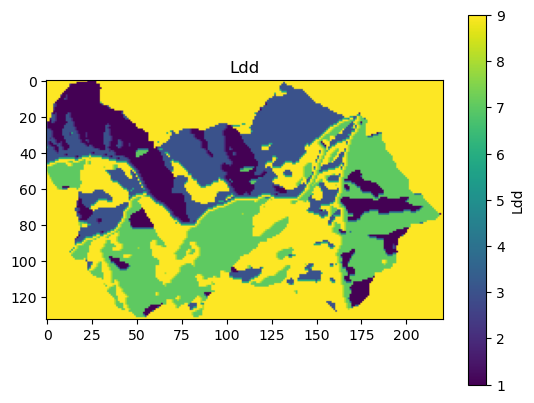

[19, 174]
[21, 168]
[78, 18]
[124, 87]
Number of pits = 4


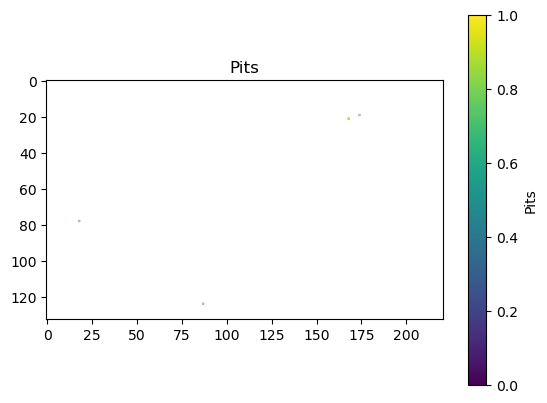

In [19]:
import os as os

Path_Input_Dem           = os.path.join(Path_Root, Path_Julia, Filename_Input_DemJulia)
Path_Output_Ldd_Basins   = os.path.join(Path_Root, Path_Python, Filename_Output_Ldd_Basins)
Path_Input_River_Geojson = os.path.join(Path_Root, Path_Gis, Filename_Input_RiverShp)

# if Param_LddMethod == "Hydromet":
#     print("==Ldd Hydromet==")

Ldd_Basins = []
if Flag_BurnRiver:
	River_Geopandas = geopandas.read_file(Path_Input_River_Geojson)
	Ldd_Basins = DEM_2_LDD_HYDROMT(
		Path_Input_Dem,
		Path_Output_Ldd_Basins,
		Param_PitMaxDepth = Param_PitMaxDepth,
		Param_RiverDepth  = Param_RiverDepth,
		Param_NoData      = Param_NoData,
		outlets           = "edge",
		River             = River_Geopandas,
		Idxs_pit          = None,
		Flag_BurnRiver    = Flag_BurnRiver)
else:
	Ldd_Basins = DEM_2_LDD_HYDROMT(
		Path_Input_Dem,
		Path_Output_Ldd_Basins,
		Param_PitMaxDepth = Param_PitMaxDepth,
		Param_RiverDepth  = Param_RiverDepth,
		Param_NoData      = Param_NoData,
		outlets           = "edge",
		River             = [],
		Idxs_pit          = None,
		Flag_BurnRiver    = Flag_BurnRiver)

PLOT_MAPS(Ldd_Basins, "Ldd", 1, 9)

# elif Param_LddMethod =="Pyflwdir":
#     print("==Ldd Pyflwdir==")
#     Ldd_Basins, Ldd_Basins_FlwdirRaster = DEM_2_LDD_PYFLWDIR(
#         Path_Input_Dem,
#         Path_Output_Ldd_Basins,
#         Param_NoData = Param_NoData,
#         outlets      = "edge",
#         River        = [],
#         Idxs_pit     = None)

#     iiPits_Vector = Ldd_Basins_FlwdirRaster.idxs_pit
#     print(iiPits_Vector)

#     if not(Ldd_Basins_FlwdirRaster.isvalid):
#         print("========= Ldd_Basins_FlwdirRaster not valid ========")


#     PLOT_MAPS(Ldd_Basins, "Ldd", 1, 9)

# elif Param_LddMethod =="Pcraster":
#     print("==Ldd Pcraster==")
#     Ldd_Basins = DEM_2_LDD_PCRASTER(
#         Path_Input_Dem,
#         Path_Output_Ldd_Basins,
#         Param_PitMaxDepth = Param_PitMaxDepth,
#         Param_RiverDepth  = Param_RiverDepth,
#         Param_NoData      = Param_NoData,
#         outlets           = "edge",
#         River             = [],
#         Idxs_pit          = None)

N_Pits_Basins, Pits = LDD_2_PITS(Ldd_Basins)

# PITS_PLOTTING(crs, Ldd_FlwdirRaster, iXY, Path_Output_Pits)


==Ldd Pyflwdir==
=== Burning rivers ====
[19, 174]
[21, 168]
[78, 18]
[124, 87]
Number of pits = 4


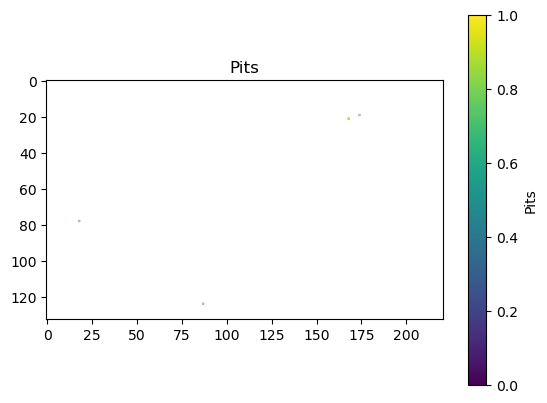

In [20]:
import os as os

Path_Input_Dem           = os.path.join(Path_Root, Path_Julia, Filename_Input_DemJulia)
Path_Output_Ldd          = os.path.join(Path_Root, Path_Python, Filename_Output_Ldd)
Path_Input_River_Geojson = os.path.join(Path_Root, Path_Gis, Filename_Input_RiverShp)
Path_Output_Pits_Bassins         = os.path.join(Path_Root, Path_Python, Filename_Output_PitsBassins)

print("==Ldd Pyflwdir==")
crs, Ldd_Basins, Ldd_BassinsFlwdirRaster = DEM_2_LDD_PYFLWDIR(
	Path_Input_Dem,
	Path_Output_Ldd,
	outlets      = "edge",
	Idxs_pit     = None)

if not(Ldd_BassinsFlwdirRaster.isvalid):
    print("========= Ldd_Basins_FlwdirRaster not valid ========")

if Flag_BurnRiver:
	River_Geopandas = geopandas.read_file(Path_Input_River_Geojson)
	Ldd_Bassins = DEM_2_LDD_HYDROMT(
		Path_Input_Dem,
		Path_Output_Ldd,
		Param_PitMaxDepth = Param_PitMaxDepth,
		Param_RiverDepth  = Param_RiverDepth,
		Param_NoData      = Param_NoData,
		outlets           = "edge",
		River             = River_Geopandas,
		Idxs_pit          = None,
		Flag_BurnRiver    = Flag_BurnRiver)
else:
	Ldd_Bassins = DEM_2_LDD_HYDROMT(
		Path_Input_Dem,
		Path_Output_Ldd,
		Param_PitMaxDepth = Param_PitMaxDepth,
		Param_RiverDepth  = Param_RiverDepth,
		Param_NoData      = Param_NoData,
		outlets           = "edge",
		River             = River_Geopandas,
		Idxs_pit          = None,
		Flag_BurnRiver    = Flag_BurnRiver)

N_Pits, Pits = LDD_2_PITS(Ldd_Bassins)

iiPits_Vector = Ldd_BassinsFlwdirRaster.idxs_pit

# PITS_PLOTTING(crs, Ldd_BassinsFlwdirRaster, iiPits_Vector, Path_Output_Pits_Bassins)

# PLOT_MAPS(Ldd, "Ldd", 1, 9)


### = **Ldd:** *subcatchment* =

==Ldd Pyflwdir==
Model coordinate pit =  [146690.0, 42120.0]
Given coordinate pit Julia =  [array([146689.917]), array([42122.998])]
=== Burning rivers ====
[20, 174]
Number of pits = 1


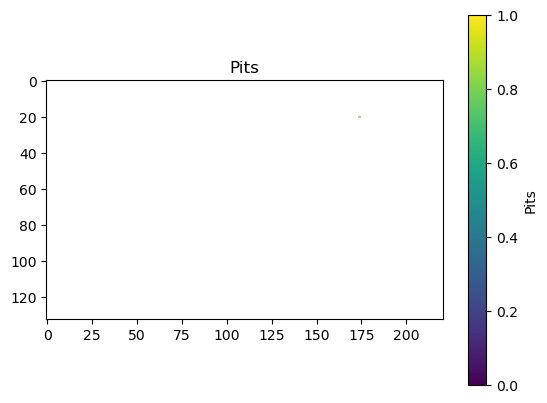

146690.0
D:/JOE/MAIN/MODELS/WFLOW/DATA/Timoleague\OutputPython\PitsSubcatchment.geojson


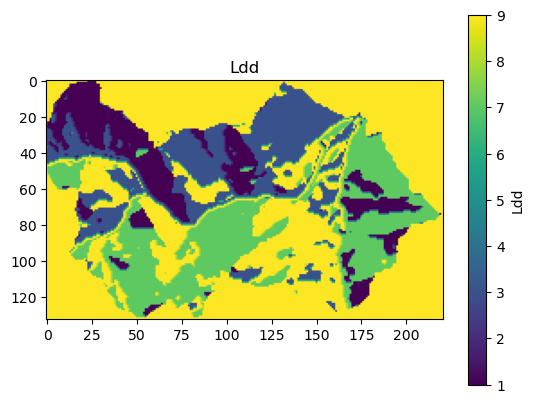

In [21]:
import os as os

Path_Input_Dem           = os.path.join(Path_Root, Path_Julia, Filename_Input_DemJulia)
Path_Output_Ldd          = os.path.join(Path_Root, Path_Python, Filename_Output_Ldd)
Path_Input_River_Geojson = os.path.join(Path_Root, Path_Gis, Filename_Input_RiverShp)
Path_Output_Pits         = os.path.join(Path_Root, Path_Python, Filename_Output_PitsSubcatchment)

print("==Ldd Pyflwdir==")
crs, Ldd, Ldd_FlwdirRaster = DEM_2_LDD_PYFLWDIR(
	Path_Input_Dem,
	Path_Output_Ldd,
	outlets      = "edge",
	Idxs_pit     = None)

iXY, Pits = XY_2_PITS(Ldd_FlwdirRaster, Param_GaugeCoordinate)

# iiPits_Vector = Ldd_FlwdirRaster.idxs_pit
# print(iiPits_Vector)

if not(Ldd_FlwdirRaster.isvalid):
    print("========= Ldd_Basins_FlwdirRaster not valid ========")

if Flag_BurnRiver:
	River_Geopandas = geopandas.read_file(Path_Input_River_Geojson)
	Ldd = DEM_2_LDD_HYDROMT(
		Path_Input_Dem,
		Path_Output_Ldd,
		Param_PitMaxDepth = Param_PitMaxDepth,
		Param_RiverDepth  = Param_RiverDepth,
		Param_NoData      = Param_NoData,
		outlets           = "idxs_pit",
		River             = River_Geopandas,
		Idxs_pit          = Pits,
		Flag_BurnRiver    = Flag_BurnRiver)
else:
	Ldd = DEM_2_LDD_HYDROMT(
		Path_Input_Dem,
		Path_Output_Ldd,
		Param_PitMaxDepth = Param_PitMaxDepth,
		Param_RiverDepth  = Param_RiverDepth,
		Param_NoData      = Param_NoData,
		outlets           = "idxs_pit",
		River             = River_Geopandas,
		Idxs_pit          = Pits,
		Flag_BurnRiver    = Flag_BurnRiver)

N_Pits, Pits = LDD_2_PITS(Ldd)

PITS_PLOTTING(crs, Ldd_FlwdirRaster, iXY, Path_Output_Pits)

PLOT_MAPS(Ldd, "Ldd", 1, 9)


## == **RUNNING:** *DEM -> DEM corrected* ==

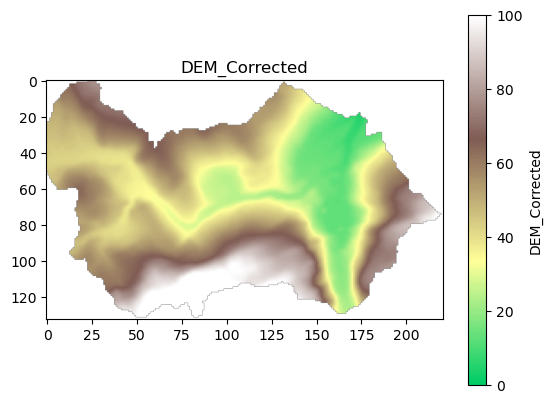

In [22]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors

Path_Input_Dem = os.path.join(Path_Root, Path_Julia, Filename_Input_DemJulia)
Path_Input_Ldd = os.path.join(Path_Root, Path_Python, Filename_Output_Ldd)
Path_Output_DemCorrected = os.path.join(Path_Root,
    Path_Python, Filename_Output_DemCorrected)

Dem_Corrected = DEM_ADJUST(
    Path_Input_Dem, Path_Input_Ldd, Path_Output_DemCorrected)

# PLOTTING
cmap_dem = colors.LinearSegmentedColormap.from_list(
    "dem", plt.cm.terrain(np.linspace(0.25, 1, 400))
)
norm_dem = colors.Normalize(vmin=0, vmax=100)
pyplot.imshow(Dem_Corrected, cmap=cmap_dem, norm=norm_dem)
pyplot.title("DEM_Corrected")
pyplot.colorbar(label="DEM_Corrected")


## == **RUNNING:** *Slope* ==

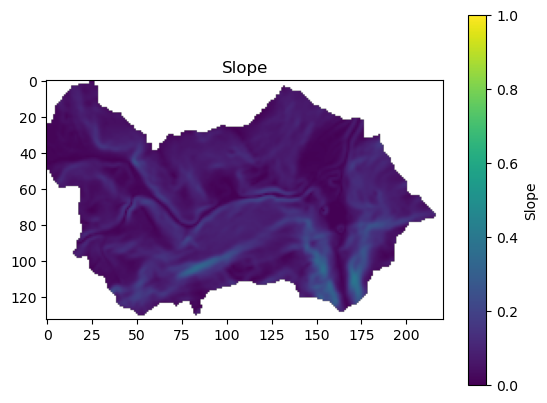

In [23]:
import os as os

Path_Input_DemCorrected = os.path.join(Path_Root, Path_Python, Filename_Output_DemCorrected)
Path_Output_Slope = os.path.join(Path_Root, Path_Python, Filename_Output_Slope)

Slope_Pyflwdir = DEM_2_SLOPE(Path_Input_DemCorrected, Path_Output_Slope)

PLOT_MAPS(Slope_Pyflwdir, "Slope", 0, 1.0)


## == **RUNNING:** *Streams* ==

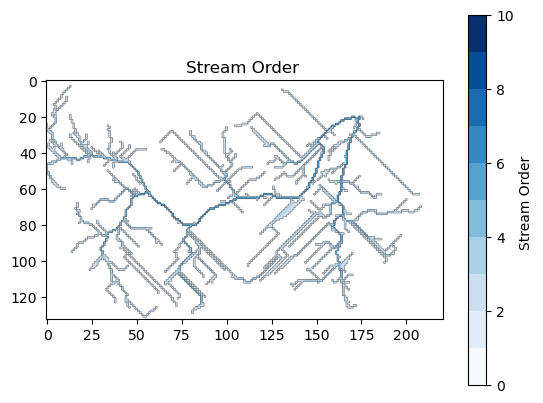

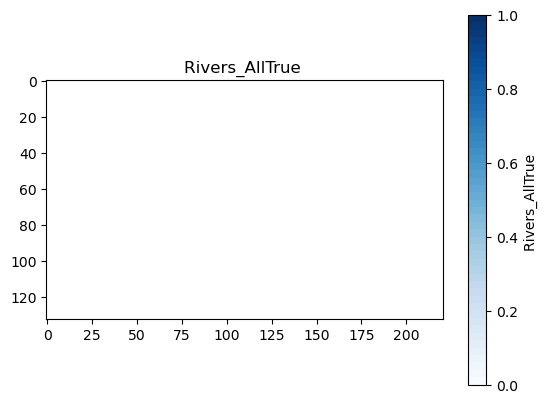

In [24]:
if Flag_River:
    Path_Input_Ldd = os.path.join(Path_Root, Path_Python, Filename_Output_Ldd)
    Path_Output_RiverOrder = os.path.join(Path_Root, Path_Python, Filename_Output_RiverOrder)
    Path_Output_RiverTrue = os.path.join(Path_Root, Path_Python, Filename_Output_RiverAllTrue)

    Rivers_AllTrue , Rivers_RiverOrder = FLOWDIRECTION_2_STREAMS(
        Path_Input_Ldd,
        Path_Output_RiverOrder,
        Path_Output_RiverTrue,
        Param_RiverOrderMax_Classic=Param_RiverOrderMax_Classic,
        Param_RiverOrderMin_Strahler=Param_RiverOrderMin_Strahler,
        Param_RiverOrderMethod=Param_RiverOrderMethod,
    )

    import matplotlib.pyplot as plt
    from matplotlib import cm, colors

    pyplot.imshow(Rivers_RiverOrder, cmap=colors.ListedColormap(
        cm.Blues(np.linspace(0, 1, 10))))

    # pyplot.imshow(Rivers_AllTrue , cmap=colors.ListedColormap(
        # cm.Blues(np.linspace(0, 1, 10))))

    PLOT_MAPS(Rivers_RiverOrder, "Stream Order ", 0, 10, Cmap=colors.ListedColormap(cm.Blues(np.linspace(0, 1, 10))))
    PLOT_MAPS(Rivers_AllTrue , "Rivers_AllTrue ", 0, 1, Cmap=colors.ListedColormap(cm.Blues(np.linspace(0, 1))))


## == **RUNNING:** *delinating bassins* ==

D:/JOE/MAIN/MODELS/WFLOW/DATA/Timoleague\OutputPython\Basins.tiff
D:/JOE/MAIN/MODELS/WFLOW/DATA/Timoleague\OutputPython\Basins.geojson


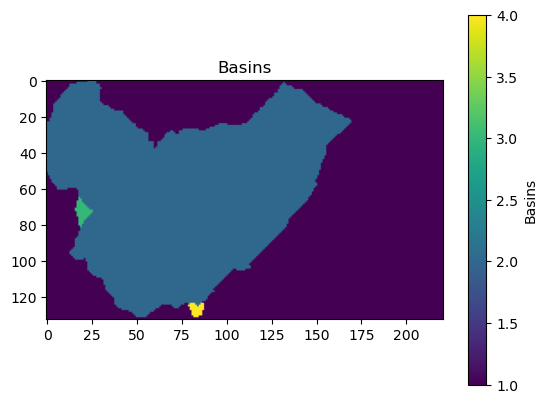

<Figure size 800x1500 with 0 Axes>

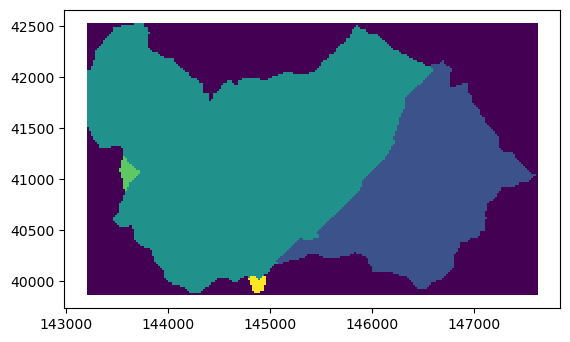

In [25]:
import os as os

if Flag_Bassins:
	Path_Input_Ldd_Basins       = os.path.join(Path_Root, Path_Python, Filename_Output_Ldd_Basins)
	Path_Output_Basins          = os.path.join(Path_Root, Path_Python, Filename_Output_Basins_Tiff)
	Path_Output_Basins_GeoPanda = os.path.join(Path_Root, Path_Python, Filename_Output_Basins_Geojson)

	Basins, Basins_Geopanda = FLOWDIRECTION_2_BASINS(Path_Input_Ldd_Basins, Path_Output_Basins, Path_Output_Basins_GeoPanda)

	PLOT_MAPS(Basins, "Basins", 1, N_Pits_Basins, Cmap="viridis")

	fig = plt.figure(figsize=(8, 15))
	Basins_Geopanda.plot("Basin")


## == **RUNNING:** *delinating subcatchment* ==

If you have no map than this may be due that Param_GaugeCoordinate is not on a river network
D:/JOE/MAIN/MODELS/WFLOW/DATA/Timoleague\OutputPython\Subcatchment.geojson


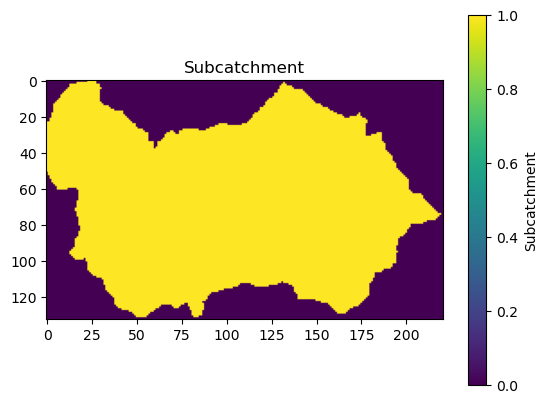

<Axes: >

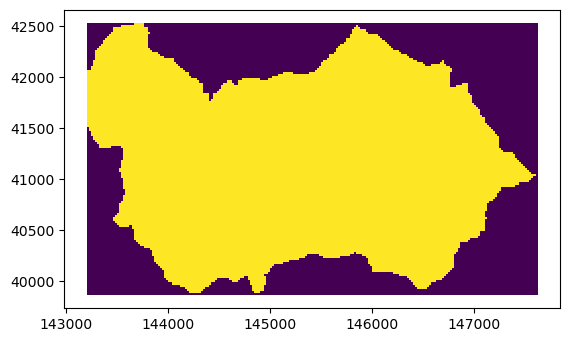

In [26]:
import os as os

Path_Input_Ldd                   = os.path.join(Path_Root, Path_Python, Filename_Output_Ldd)
Path_Output_Subcatchment         = os.path.join(Path_Root, Path_Python, Filename_Output_Subcatchment)
Path_Output_Subcatchment_Geojson = os.path.join(Path_Root, Path_Python, Filename_Output_Subcatchment_Geojson)

print("If you have no map than this may be due that Param_GaugeCoordinate is not on a river network")

Subcatchment, Subcatchment_Geopanda = FLOWDIRECTION_2_SUBCATCHMENT_OUTLET(Param_GaugeCoordinate,
    Path_Input_Ldd,
    Path_Output_Subcatchment,
    Path_Output_Subcatchment_Geojson,
    Name="Subcatchment")

pyplot.imshow(Subcatchment)

PLOT_MAPS(Subcatchment, "Subcatchment", 0, 1, Cmap="viridis")
Subcatchment_Geopanda.plot("Subcatchment")


## == **RUNNING:** *river length* ==

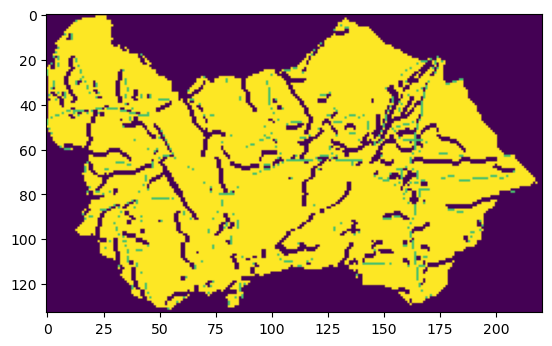

In [27]:

Path_Output_Ldd = os.path.join(Path_Root, Path_Python, Filename_Output_Ldd)
Path_Output_RiverLength = os.path.join(Path_Root, Path_Python, Filename_Output_RiverLength)

River_Length = RIVER_LENGTH(Path_Output_Ldd, Path_Output_RiverLength)

pyplot.imshow(River_Length)


# **MASK**

In [28]:
# Nx, Ny = np.shape(Subcatchment)
# Ldd_Mask = np.ma.empty(shape=(Nx, Ny))
# for iX in range(Nx):
#     for iY in range(Ny):
#         if Subcatchment[iX, iY] > 0:
# 			if Ldd[iX, iY] == 5:
# 				Ldd_Mask[iX, iY] = Ldd[iX, iY]
# 			else:
# 				Ldd_Mask[iX, iY] = np.nan
# 			else:
#             # Ldd_Mask[iX, iY] = np.nan

# pyplot.imshow(Ldd_Mask)
# # Path_Output_LddMask = os.path.join(Path_Root, Path_Python, "LddMask.tiff")
# # prof.update(dtype=rasterio.float64, nodata=False)
# # with rasterio.open(Path_Output_LddMask, "w", **prof) as src:
# # 	src.write(Ldd_Mask, 1)



# =========================================================================================================

# OLD CODE

## **RERUN DLL WITH MASK**

In [29]:
# import os as os
# import numpy as np

# Option_Model = "DEM_2_LDD_PYFLWDIR"  # <"DEM_2_LDD_HYDROMT">,<DEM_2_LDD_PYFLWDIR>

# Path_Input_Catchment = os.path.join(Path_Root, Path_Python, Filename_Output_Subcatchment)

# with rasterio.open(Path_Input_Catchment, "r") as src:
#     Catchment = src.read(1)
#     nodata = src.nodata
#     transform = src.transform
#     crs = src.crs
#     latlon = src.crs.is_geographic
#     prof = src.profile

# Path_Input_Dem = os.path.join(Path_Root, Path_Julia, Filename_Input_DemJulia)

# with rasterio.open(Path_Input_Dem, "r") as src:
#     Dem = src.read(1)
#     nodata = src.nodata
#     transform = src.transform
#     crs = src.crs
#     latlon = src.crs.is_geographic
#     prof = src.profile

# # Masking
# Nx, Ny = np.shape(Dem)

# Dem_Mask = np.ma.empty(shape=(Nx, Ny))
# for iX in range(Nx):
#     for iY in range(Ny):
#         if Catchment[iX, iY] > 0:
#             Dem_Mask[iX, iY] = Dem[iX, iY]
#         else:
#             Dem_Mask[iX, iY] = np.nan

# # Writting masked
# Path_Output_DemMasked = os.path.join(Path_Root, Path_Julia, Filename_Output_DemCorrectedMasked)
# prof.update(dtype=rasterio.float64, nodata=np.nan)
# with rasterio.open(Path_Output_DemMasked, "w", **prof) as src:
#     src.write(Dem_Mask, 1)

# # Rerunning the Ldd with the masked DEM
# Path_Output_Ldd = os.path.join(Path_Root, Path_Python, Filename_Output_Ldd)

# if Option_Model == "DEM_2_LDD_HYDROMT":
#     Ldd_Pyflwdir = DEM_2_LDD_HYDROMT(
#         Path_Output_DemMasked,
#         Path_Output_Ldd,
#         Param_PitMaxDepth=Param_PitMaxDepth,
#         Param_RiverDepth=Param_RiverDepth,
#         Param_NoData=Param_NoData,
#         outlets=Param_OutletMethod,
#         River=River_Geopandas,
#         Idxs_pit=None,
#     )
#     PLOT_MAPS(Ldd_Pyflwdir, "Ldd", 0, 10)

# else:
#     Ldd_Pyflwdir, Ldd_Array = DEM_2_LDD_PYFLWDIR(
#         Path_Output_DemMasked, Path_Output_Ldd, Param_PitMaxDepth=Param_PitMaxDepth, Gauges=Param_OutletMethod)

#     PLOT_MAPS(Ldd_Array, "Ldd", 0, 10)


In [30]:
    # Outlet_ShapeFile = gpd.GeoSeries(gpd.points_from_xy(X, Y, crs=crs))

    # idxs1, dists = Ldd.snap(idxs=None, xy=(X, Y), mask=Ldd.stream_order() == Param_StreamOrderSnap_Strahler, max_length=None, unit='cell', direction='down')
    # Convert idx_2_xy
    # xy1 = Ldd.xy(idxs1)
# gdf_pnts1 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(*xy1), crs=crs).reset_index()


In [31]:
gdf_out = gpd.GeoSeries(gpd.points_from_xy(*flw.xy(idxs_out), crs=4326))

# flow paths return the list of linear indices
xy = ([8.92, 5.55, 8.50], [50.28, 49.80, 47.3])
flowpaths, dists = flw.path(xy=xy, max_length=400e3, unit="m")
# note that all distances are nearly at the threshold
dists / 1e3

coords_to_idxs(xs, ys, transform, shape, op=np.floor, precision=None):

FlwdirRaster.index(xs, ys, **kwargs)
FlwdirRaster.xy(idxs, **kwargs)

FlwdirRaster.add_pits(idxs=None, xy=None, streams=None)[source]
Add pits the flow direction raster. If streams is given, the pits are snapped to the first downstream True cell.

Parameters
:
idxs (array_like, optional) – linear indices of pits, by default is None.

xy (tuple of array_like of float, optional) – x, y coordinates of pits, by default is None.

streams (2D array of bool, optional) – 2D raster with cells flagged ‘True’ at stream cells, only used in combination with idx or xy, by default None.

feats = flw.streams(min_sto=4)
gdf = gpd.GeoDataFrame.from_features(feats, crs=crs)


SyntaxError: invalid character '–' (U+2013) (3714598091.py, line 19)

In [ ]:
import rasterio
import numpy as np

with rasterio.open(r'F:\projects\ordos_flood\Naeem\DEM\Taolimiao_500m/flwdir0.tif') as src:       # input file path
    image = src.read(1)  # read the first band
    mask = src.dataset_mask()  # get the mask, non-zero means active pixel


    # for edge detecting
    edges = mask == 0
    dilated = np.logical_or(edges, np.roll(edges, 1, axis=0))
    dilated = np.logical_or(dilated, np.roll(edges, -1, axis=0))
    dilated = np.logical_or(dilated, np.roll(edges, 1, axis=1))
    dilated = np.logical_or(dilated, np.roll(edges, -1, axis=1))


    # set pixel value in the edge to zero
    image[dilated] = 0


    # save the revised image
    profile = src.profile
    with rasterio.open(r'F:\projects\ordos_flood\Naeem\DEM\Taolimiao_500m/flwdir.tif', 'w', **profile) as dst:    # output file path
        dst.write(image, 1)

#########################################
